In [7]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
from lstmModel import LstmModel 
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import pandas as pd
import os

In [8]:
import access_br_dwgd

timeseries = access_br_dwgd.recuperar_dados_br_dwgd()
train_size = int(len(timeseries) * 0.7)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]


Dados carregados com sucesso para a estação: 2552000
Total de 23081 dias válidos no período selecionado.


In [9]:
import lstm

lookback = 5
X_train, y_train = lstm.create_dataset(train, lookback=lookback)
X_test, y_test = lstm.create_dataset(test, lookback=lookback)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([16151, 5, 1]) torch.Size([16151, 5, 1])
torch.Size([6920, 5, 1]) torch.Size([6920, 5, 1])


In [10]:
model = LstmModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

In [11]:
n_epochs = 30
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = torch.sqrt(loss_fn(y_pred, y_train)).item()
        y_pred = model(X_test)
        test_rmse = torch.sqrt(loss_fn(y_pred, y_test)).item()
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 13.8617, test RMSE 14.7901
Epoch 1: train RMSE 13.8607, test RMSE 14.7747
Epoch 2: train RMSE 13.8529, test RMSE 14.7936
Epoch 3: train RMSE 13.8470, test RMSE 14.7850
Epoch 4: train RMSE 13.8479, test RMSE 14.7804
Epoch 5: train RMSE 13.8454, test RMSE 14.7793
Epoch 6: train RMSE 13.8423, test RMSE 14.7785
Epoch 7: train RMSE 13.8423, test RMSE 14.7826
Epoch 8: train RMSE 13.8387, test RMSE 14.7753
Epoch 9: train RMSE 13.8354, test RMSE 14.7758
Epoch 10: train RMSE 13.8365, test RMSE 14.7779
Epoch 11: train RMSE 13.8352, test RMSE 14.7755
Epoch 12: train RMSE 13.8362, test RMSE 14.7864
Epoch 13: train RMSE 13.8330, test RMSE 14.7830
Epoch 14: train RMSE 13.8300, test RMSE 14.7758
Epoch 15: train RMSE 13.8269, test RMSE 14.7764
Epoch 16: train RMSE 13.8297, test RMSE 14.7727
Epoch 17: train RMSE 13.8253, test RMSE 14.7763
Epoch 18: train RMSE 13.8223, test RMSE 14.7800
Epoch 19: train RMSE 13.8224, test RMSE 14.7744
Epoch 20: train RMSE 13.8201, test RMSE 14.7784
Ep

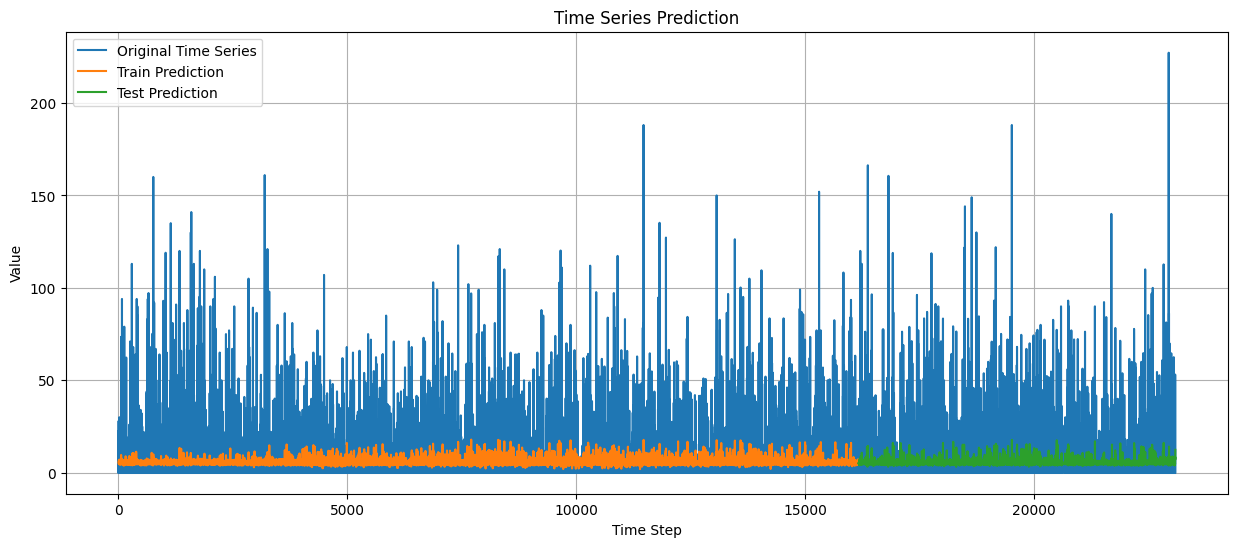

In [12]:
model.eval()
with torch.no_grad():
    # Previsões do modelo
    train_pred = model(X_train)[:, -1, :].squeeze().cpu().numpy()
    test_pred = model(X_test)[:, -1, :].squeeze().cpu().numpy()

# Inicializa arrays com NaN para plotar nas posições corretas
full_len = len(timeseries)
train_plot = np.full(full_len, np.nan)
test_plot = np.full(full_len, np.nan)

# Alinha previsões de treino
train_plot[lookback:lookback + len(train_pred)] = train_pred

# Alinha previsões de teste
test_plot[train_size + lookback : train_size + lookback + len(test_pred)] = test_pred

# Plot
plt.figure(figsize=(15, 6))
plt.plot(timeseries, label='Original Time Series')
plt.plot(train_plot, label='Train Prediction')
plt.plot(test_plot, label='Test Prediction')
plt.legend()
plt.title('Time Series Prediction')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid(True)
plt.show()